In [11]:
import numpy as np
import pandas as pd
import os, datetime
import pickle
import tensorflow as tf
import yfinance as yf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import sys
sys.path.append('../../')
from Backtest import Backtest,Position,Bid
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
import keras

Tensorflow version: 2.9.1


In [12]:
def get_data(tickers,length,interval):
    data =  yf.download(tickers = tickers, 
    period = length, interval = interval, group_by = 'ticker',
    auto_adjust = True,
    prepost = False,
    threads = True,
    proxy = None
)

    data = data.loc[:, pd.IndexSlice[:, ['Close']]]

    columns = data.columns.droplevel(1)

    data.columns = columns 

    data.sort_index(axis = 1, inplace = True)
    #data = data.reset_index(drop = True)
    return data.dropna()

In [13]:
with open("sp100tickers.pickle", "rb") as f:
            tickers = pickle.load(f)

In [14]:
data = get_data(tickers,'1440d','1d')
data

[*********************100%***********************]  100 of 100 completed


AAPL        ABBV         ABT         ACN        ADBE  \
Date                                                                     
2019-03-20   45.672222   67.746765   75.681816  158.183136  259.739990   
2019-03-21   47.354347   68.429031   75.795410  160.057343  264.179993   
2019-03-22   46.373726   67.182426   73.816757  157.203232  259.690002   
2019-03-25   45.813011   66.971848   74.062897  157.051010  262.269989   
2019-03-26   45.339687   68.024727   74.791878  158.820587  265.589996   
...                ...         ...         ...         ...         ...   
2022-09-30  138.199997  134.210007   96.760002  257.299988  275.200012   
2022-10-03  142.449997  138.320007   99.519997  264.890015  285.239990   
2022-10-04  146.100006  141.990005  103.080002  274.309998  294.970001   
2022-10-05  146.399994  143.330002  103.379997  274.339996  297.380005   
2022-10-07  140.089996  138.759995  101.790001  259.709991  288.769989   

                  AIG        AMGN         AMT        AMZN        AVGO  ...  \
Date                                                                   ...   
2019-03-20  38.793434  172.204132  179.086060   89.863503  256.562805  ...   
2019-03-21  39.217861  172.897919  182.049957   90.962997  261.649445  ...   
2019-03-22  38.486420  168.221603  181.058868   88.238503  257.990936  ...   
2019-03-25  38.332901  168.122452  182.966263   88.712997  257.558990  ...   
2019-03-26  38.874706  169.636215  182.367874   89.188004  261.852173  ...   
...               ...         ...         ...         ...         ...  ...   
2022-09-30  47.480000  225.399994  214.699997  113.000000  444.010010  ...   
2022-10-03  49.180000  230.440002  217.169998  115.879997  456.779999  ...   
2022-10-04  51.709999  233.020004  220.080002  121.089996  479.859985  ...   
2022-10-05  51.299999  233.820007  214.139999  120.949997  484.799988  ...   
2022-10-07  49.709999  229.029999  194.630005  114.559998  460.480011  ...   

                   UNH         UNP         UPS        USB           V  \
Date                                                                    
2019-03-20  237.594437  149.610031   97.356361  44.043076  150.371964   
2019-03-21  239.036118  151.106140   99.052338  43.422245  152.376892   
2019-03-22  234.360092  149.256897   96.842140  42.215591  149.706894   
2019-03-25  234.141953  150.074646   96.436195  42.058197  149.667755   
2019-03-26  230.850693  150.362717   97.798386  42.416695  151.887924   
...                ...         ...         ...        ...         ...   
2022-09-30  505.040009  194.820007  161.539993  40.320000  177.649994   
2022-10-03  515.510010  200.259995  163.089996  41.570000  181.649994   
2022-10-04  523.169983  205.380005  168.889999  42.630001  185.649994   
2022-10-05  527.070007  200.619995  167.929993  42.200001  187.669998   
2022-10-07  504.850006  195.619995  159.139999  40.200001  183.830002   

                   VZ        WBA        WFC         WMT         XOM  
Date                                                                 
2019-03-20  48.581097  54.631924  45.600056   93.002449   66.370705  
2019-03-21  49.103386  55.336674  45.111473   93.398430   66.754303  
2019-03-22  50.341717  54.301296  43.709099   92.663002   65.685112  
2019-03-25  50.611279  53.674843  43.501003   92.559311   65.228065  
2019-03-26  51.074596  53.874958  44.342422   92.700722   66.076874  
...               ...        ...        ...         ...         ...  
2022-09-30  37.340702  31.400000  40.220001  129.699997   87.309998  
2022-10-03  38.510979  32.430000  41.580002  132.529999   91.919998  
2022-10-04  39.150208  33.389999  43.540001  134.250000   95.269997  
2022-10-05  38.747002  33.160000  43.310001  132.919998   99.120003  
2022-10-07  36.849998  30.520000  41.790001  128.559998  101.029999  

[896 rows x 100 columns]

In [20]:
class BTLSTM:
    def __init__(self):
        self.model = keras.models.load_model("stockprediction.h5")
    
    def get_prediction(self,X):
        scaler = MinMaxScaler(feature_range=(0, 1))
        my_array = X.reshape(-1, 1)
        scaled_Close = scaler.fit_transform(my_array)
        scaled_X = scaled_Close.reshape((1, 1, 10))
        y = self.model.predict(scaled_X)
        b = scaler.inverse_transform(y)
        r = (b[0] - X[-1]) / X[-1]
        return r[0]
    
    def get_target_stocks(self,df):
        if len(df) < 10:
            return []
        res_dict = {}
        for ticker in df.columns:
            df[ticker+"_X"] = list(df[ticker].rolling(window=10))
            df[ticker+"_X"] = df[ticker+"_X"].apply(lambda x:x.values)

            ret = self.get_prediction(df[ticker+"_X"].iloc[-1])
            if ret > 0:
                res_dict[ticker] = ret

        res_dict = {k: v for k, v in sorted(res_dict.items(), key=lambda item: item[1], reverse = True)}

        return list(res_dict.keys())[:10]
    
    def predict(self,ti,df,positions,cash,full_data):
            
        print(ti)
        bid_list = []
        for pos in positions.values():
            #ticker
            ticker = pos.ticker
            #latest price
            price = df.iloc[-1][pos.ticker]
            #shares held in current position
            shares_held = pos.shares

            bid = Bid(ticker = ticker,shares = shares_held,price = price,bid_type = 0)
            bid_list.append(bid)

            cash += shares_held*price

        df_X = df.iloc[-10:].copy(deep = True)

        tickers = self.get_target_stocks(df_X)

        if len(tickers) != 0:
            weight = cash/len(tickers)

        for ticker in tickers:
            #latest price
            price = df.iloc[-1][ticker]
            shares = weight//price

            bid = Bid(ticker = ticker, shares = shares, price = price,bid_type = 1)
            bid_list.append(bid)

        return bid_list

In [21]:
model = keras.models.load_model("stockprediction.h5")
lstm = BTLSTM()
model_bt = Backtest(data,lstm,has_tc = False)

In [22]:
model_bt.backtest_full()

2019-03-20 00:00:00
2019-03-21 00:00:00
2019-03-22 00:00:00
2019-03-25 00:00:00
2019-03-26 00:00:00
2019-03-27 00:00:00
2019-03-28 00:00:00
2019-03-29 00:00:00
2019-04-01 00:00:00
2019-04-02 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-04-03 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2019-04-04 00:00:00
1/1 [==============================] - 0s 21ms/step
2019-04-05 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
2019-04-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
2019-04-09 00:00:00
1/1 [==============================] - 0s 22ms/step
2019-04-10 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
2019-04-11 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-04-12 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-04-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-04-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-04-17 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-04-18 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step
2019-04-22 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-04-23 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2019-04-24 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-04-25 00:00:00
1/1 [==============================] - 0s 17ms/step
2019-04-26 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-04-29 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-04-30 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-05-01 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-05-02 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
2019-05-03 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-05-06 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
2019-05-07 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-05-08 00:00:00


1/1 [==============================] - 0s 15ms/step
2019-05-09 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-05-10 00:00:00
1/1 [==============================] - 0s 14ms/step
2019-05-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-05-14 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-05-15 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-05-16 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2019-05-17 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-05-20 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-05-21 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-05-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-05-23 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-05-24 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
2019-05-28 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-05-29 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-05-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-05-31 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-06-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-06-04 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-06-05 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-06-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-06-07 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-06-10 00:00:00
1/1 [==============================] - 0s 17ms/step
2019-06-11 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2019-06-12 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-06-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-06-14 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-06-17 00:00:00
1/1 [==============================] - 0s 19ms/step
2019-06-18 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
2019-06-19 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-06-20 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-06-21 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2019-06-24 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-06-25 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-06-26 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-06-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-06-28 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-07-01 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-07-02 00:00:00
1/1 [==============================] - 0s 14ms/step
2019-07-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2019-07-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-07-08 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-07-09 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2019-07-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-07-11 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-07-12 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-07-15 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-07-16 00:00:00
1/1 [==============================] - 0s 19ms/step
2019-07-17 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2019-07-18 00:00:00
1/1 [==============================] - 0s 14ms/step
2019-07-19 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-07-22 00:00:00
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step
2019-07-23 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-07-24 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step
2019-07-25 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-07-26 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-07-29 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2019-07-30 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2019-07-31 00:00:00
1/1 [==============================] - 0s 18ms/step
2019-08-01 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
2019-08-02 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-08-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
2019-08-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2019-08-07 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-08-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-08-09 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2019-08-12 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-08-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-08-14 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-08-15 00:00:00
1/1 [==============================] - 0s 17ms/step
2019-08-16 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-08-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2019-08-20 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-08-21 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-08-22 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-08-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-08-26 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
2019-08-27 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-08-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-08-29 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2019-08-30 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-09-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-09-04 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-09-05 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-09-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-09-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-09-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-09-11 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
2019-09-12 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-09-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-09-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-09-17 00:00:00
1/1 [==============================] - 0s 17ms/step
2019-09-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
2019-09-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-09-20 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-09-23 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-09-24 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-09-25 00:00:00


1/1 [==============================] - 0s 15ms/step
2019-09-26 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-09-27 00:00:00
1/1 [==============================] - 0s 18ms/step
2019-09-30 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-01 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-02 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-10-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-04 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-10-07 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-10-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-09 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-10 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-10-11 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-10-14 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-10-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
2019-10-16 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-10-17 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-10-18 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-10-21 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2019-10-22 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-10-23 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
2019-10-24 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-25 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-10-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-29 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-10-30 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-10-31 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2019-11-01 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-11-04 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-11-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-11-06 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-11-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-11-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2019-11-11 00:00:00
1/1 [==============================] - 0s 17ms/step
2019-11-12 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
2019-11-13 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
2019-11-14 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-11-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2019-11-18 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-11-19 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2019-11-20 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-11-21 00:00:00
1/1 [==============================] - 0s 17ms/step
2019-11-22 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2019-11-25 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
2019-11-26 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-11-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-11-29 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-12-02 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-12-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2019-12-04 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-12-05 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-12-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2019-12-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2019-12-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2019-12-11 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
2019-12-12 00:00:00
1/1 [==============================] - 0s 17ms/step
2019-12-13 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 16ms/step
2019-12-16 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
2019-12-17 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-12-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2019-12-19 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-12-20 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2019-12-23 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
2019-12-24 00:00:00
1/1 [==============================] - 0s 21ms/step
2019-12-26 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
2019-12-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2019-12-30 00:00:00
1/1 [==============================] - 0s 15ms/step
2019-12-31 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-01-02 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-01-03 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-01-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-01-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-01-08 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-01-09 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
2020-01-10 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-01-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-01-14 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-01-15 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-01-16 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-01-17 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-01-21 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-01-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-01-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-01-24 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-01-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-01-28 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-01-29 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-01-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-01-31 00:00:00
1/1 [==============================] - 0s 22ms/step
2020-02-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-02-04 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-02-05 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-02-06 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-02-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-02-10 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-02-11 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
2020-02-12 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-02-13 00:00:00


1/1 [==============================] - 0s 16ms/step
2020-02-14 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
2020-02-18 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-02-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-02-20 00:00:00
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
2020-02-21 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-02-24 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-02-25 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-02-26 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-02-27 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-02-28 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-03-02 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-03-03 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-03-04 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-03-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-03-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-03-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-03-10 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
2020-03-11 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 20ms/step
2020-03-12 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-03-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-03-16 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2020-03-17 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-03-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-03-19 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-03-20 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
2020-03-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-03-24 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-03-25 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-03-26 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-03-27 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-03-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-03-31 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
2020-04-01 00:00:00
1/1 [==============================] - 0s 19ms/step
2020-04-02 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
2020-04-03 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
2020-04-06 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-04-07 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
2020-04-08 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-04-09 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2020-04-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-04-14 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-04-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-04-16 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 27ms/step
2020-04-17 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-04-20 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 22ms/step
2020-04-21 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2020-04-22 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-04-23 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-04-24 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-04-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-04-28 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-04-29 00:00:00
1/1 [==============================] - 0s 18ms/step
2020-04-30 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2020-05-01 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
2020-05-04 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-05-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-05-06 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
2020-05-07 00:00:00
1/1 [==============================] - 0s 18ms/step
2020-05-08 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 27ms/step
2020-05-11 00:00:00
1/1 [==============================] - 0s 23ms/step
2020-05-12 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2020-05-13 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
2020-05-14 00:00:00
1/1 [==============================] - 0s 20ms/step
2020-05-15 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-05-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-05-19 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-05-20 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-05-21 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2020-05-22 00:00:00
1/1 [==============================] - 0s 18ms/step
2020-05-26 00:00:00
1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 16ms/step
2020-05-27 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-05-28 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-05-29 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
2020-06-01 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-06-02 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-06-03 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-06-04 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-06-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2020-06-08 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-06-09 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-06-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-06-11 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 23ms/step
2020-06-12 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-06-15 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
2020-06-16 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-06-17 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-06-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-06-19 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-06-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-06-23 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
2020-06-24 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-06-25 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-06-26 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-06-29 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-06-30 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
2020-07-01 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-07-02 00:00:00


1/1 [==============================] - 0s 15ms/step
2020-07-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 22ms/step
2020-07-07 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-07-08 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-07-09 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
2020-07-10 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-07-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-07-14 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-07-15 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-07-16 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2020-07-17 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-07-20 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-07-21 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-07-22 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-07-23 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-07-24 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-07-27 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-07-28 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-07-29 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-07-30 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-07-31 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-03 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-08-04 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-08-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-06 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-08-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-11 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-08-12 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-08-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-08-14 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-08-17 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2020-08-18 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-08-19 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-08-20 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-21 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-24 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-08-25 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-26 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-08-27 00:00:00
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-28 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-08-31 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-09-01 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-09-02 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-09-03 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-09-04 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-09-08 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-09-09 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-09-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-09-11 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-09-14 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-09-15 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-09-16 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-09-17 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
2020-09-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
2020-09-21 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-09-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-09-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-09-24 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-09-25 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-09-28 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-09-29 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-09-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
2020-10-01 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-10-02 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-10-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-10-06 00:00:00
1/1 [==============================] - 0s 18ms/step
2020-10-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-10-08 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-10-09 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-10-12 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2020-10-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-10-14 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-10-15 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2020-10-16 00:00:00
1/1 [==============================] - 0s 19ms/step
2020-10-19 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 30ms/step
2020-10-20 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2020-10-21 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-10-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-10-23 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2020-10-26 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-10-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-10-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-10-29 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-10-30 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2020-11-02 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-11-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2020-11-04 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-11-05 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-11-06 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2020-11-09 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 57ms/step
2020-11-10 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-11-11 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-11-12 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-11-13 00:00:00
1/1 [==============================] - 0s 17ms/step
2020-11-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2020-11-17 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-11-18 00:00:00


1/1 [==============================] - 0s 15ms/step
2020-11-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-11-20 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-11-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2020-11-24 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-11-25 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-11-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2020-11-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-12-01 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-12-02 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
2020-12-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2020-12-04 00:00:00
1/1 [==============================] - 0s 19ms/step
2020-12-07 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-12-08 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-12-09 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2020-12-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-12-11 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-12-14 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2020-12-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2020-12-16 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-12-17 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step
2020-12-18 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2020-12-21 00:00:00
1/1 [==============================] - 0s 15ms/step
2020-12-22 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2020-12-23 00:00:00
1/1 [==============================] - 0s 16ms/step
2020-12-24 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
2020-12-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2020-12-29 00:00:00
1/1 [==============================] - 0s 27ms/step
2020-12-30 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 24ms/step
2020-12-31 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-01-04 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-01-05 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-01-06 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2021-01-07 00:00:00
1/1 [==============================] - 0s 20ms/step
2021-01-08 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
2021-01-11 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-01-12 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-01-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-01-14 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-01-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-01-19 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-01-20 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-01-21 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-01-22 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-01-25 00:00:00
1/1 [==============================] - 0s 20ms/step
2021-01-26 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
2021-01-27 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-01-28 00:00:00
1/1 [==============================] - 0s 18ms/step
2021-01-29 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
2021-02-01 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-02-02 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2021-02-03 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
2021-02-04 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-02-05 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-02-08 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
2021-02-09 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-02-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-02-11 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-02-12 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-02-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-02-17 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-02-18 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-02-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-02-22 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-02-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-02-24 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-02-25 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-02-26 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-01 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-02 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-03-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-04 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-03-05 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-03-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-03-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-03-11 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-12 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-03-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-03-17 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-03-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-03-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2021-03-22 00:00:00
1/1 [==============================] - 0s 25ms/step
2021-03-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-03-24 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-03-25 00:00:00
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 21ms/step
2021-03-26 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-29 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-03-30 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
2021-03-31 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
2021-04-01 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-04-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-04-06 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2021-04-07 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-04-08 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2021-04-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-04-12 00:00:00


1/1 [==============================] - 0s 20ms/step
2021-04-13 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2021-04-14 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-04-15 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2021-04-16 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2021-04-19 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-04-20 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-04-21 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2021-04-22 00:00:00
1/1 [==============================] - 0s 18ms/step
2021-04-23 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 17ms/step
2021-04-26 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 23ms/step
2021-04-27 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-04-28 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2021-04-29 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-04-30 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-05-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-05-04 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-05-05 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-05-06 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-05-07 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-05-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-05-11 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
2021-05-12 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-05-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-05-14 00:00:00
1/1 [==============================] - 0s 23ms/step
2021-05-17 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
2021-05-18 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 18ms/step
2021-05-19 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-05-20 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-05-21 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 28ms/step
2021-05-24 00:00:00
1/1 [==============================] - 0s 20ms/step
2021-05-25 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
2021-05-26 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-05-27 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-05-28 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2021-06-01 00:00:00
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step
2021-06-02 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-06-03 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
2021-06-04 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-06-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-06-08 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-06-09 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-06-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-06-11 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2021-06-14 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-06-15 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
2021-06-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-06-17 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-06-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2021-06-21 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-06-22 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 17ms/step
2021-06-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-06-24 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-06-25 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
2021-06-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-06-29 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-06-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-07-01 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2021-07-02 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-07-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-07-07 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-07-08 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
2021-07-09 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-07-12 00:00:00
1/1 [==============================] - 0s 14ms/step
2021-07-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-07-14 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-07-15 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-07-16 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2021-07-19 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2021-07-20 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-07-21 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-07-22 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2021-07-23 00:00:00
1/1 [==============================] - 0s 18ms/step
2021-07-26 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-07-27 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-07-28 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-07-29 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2021-07-30 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-08-02 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-03 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
2021-08-04 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-08-05 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-06 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-09 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-08-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-11 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-08-12 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-16 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-08-17 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-08-19 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-08-20 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-08-23 00:00:00
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step
2021-08-24 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-08-25 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-08-26 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-08-27 00:00:00


1/1 [==============================] - 0s 20ms/step
2021-08-30 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-08-31 00:00:00
1/1 [==============================] - 0s 22ms/step
2021-09-01 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-09-02 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-09-03 00:00:00
1/1 [==============================] - 0s 24ms/step
2021-09-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-09-08 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
2021-09-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-09-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2021-09-13 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-09-14 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-09-15 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
2021-09-16 00:00:00
1/1 [==============================] - 0s 22ms/step
2021-09-17 00:00:00
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 18ms/step
2021-09-20 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2021-09-21 00:00:00
1/1 [==============================] - 0s 19ms/step
2021-09-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-09-23 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-09-24 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-09-27 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step
2021-09-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2021-09-29 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-09-30 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step
2021-10-01 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-10-04 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-10-05 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2021-10-06 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-10-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-10-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-10-11 00:00:00
1/1 [==============================] - 0s 18ms/step
2021-10-12 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-10-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
2021-10-14 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-10-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2021-10-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2021-10-19 00:00:00
1/1 [==============================] - 0s 14ms/step
2021-10-20 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-10-21 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-10-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-10-25 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-10-26 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-10-27 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2021-10-28 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-10-29 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-11-01 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-11-02 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-11-03 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-11-04 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-11-05 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-11-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2021-11-09 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-11-10 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-11-11 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2021-11-12 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-11-15 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-11-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
2021-11-17 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-11-18 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-11-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-11-22 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-11-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-11-24 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-11-26 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-11-29 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2021-11-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-01 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-12-02 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-06 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-12-07 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-12-08 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-12-10 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
2021-12-13 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-12-14 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-12-15 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-12-16 00:00:00
1/1 [==============================] - 0s 17ms/step
2021-12-17 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-20 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-21 00:00:00
1/1 [==============================] - 0s 15ms/step
2021-12-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2021-12-23 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-27 00:00:00
1/1 [==============================] - 0s 19ms/step
2021-12-28 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2021-12-29 00:00:00
1/1 [==============================] - 0s 16ms/step
2021-12-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2021-12-31 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-01-03 00:00:00
1/1 [==============================] - 0s 17ms/step
2022-01-04 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2022-01-05 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
2022-01-06 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-01-07 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
2022-01-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-01-11 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-01-12 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-01-13 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-01-14 00:00:00


1/1 [==============================] - 0s 17ms/step
2022-01-18 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 20ms/step
2022-01-19 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-01-20 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-01-21 00:00:00
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 49ms/step
2022-01-24 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-01-25 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
2022-01-26 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
2022-01-27 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-01-28 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2022-01-31 00:00:00
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 17ms/step
2022-02-01 00:00:00
1/1 [==============================] - 0s 17ms/step
2022-02-02 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
2022-02-03 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-02-04 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2022-02-07 00:00:00
1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 15ms/step
2022-02-08 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-02-09 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2022-02-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-02-11 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-02-14 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 20ms/step
2022-02-15 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-02-16 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-02-17 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-02-18 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-02-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2022-02-23 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
2022-02-24 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-02-25 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2022-02-28 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step
2022-03-01 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-03-02 00:00:00
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step
2022-03-03 00:00:00
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 15ms/step
2022-03-04 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-03-07 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2022-03-08 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2022-03-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-03-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-03-11 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-03-14 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-03-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2022-03-16 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-03-17 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2022-03-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-03-21 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-03-22 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2022-03-23 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2022-03-24 00:00:00
1/1 [==============================] - 0s 21ms/step
2022-03-25 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
2022-03-28 00:00:00
1/1 [==============================] - 0s 17ms/step
2022-03-29 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2022-03-30 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-03-31 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-04-01 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 21ms/step
2022-04-04 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-04-05 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-04-06 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
2022-04-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-04-08 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-04-11 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 18ms/step
2022-04-12 00:00:00
1/1 [==============================] - 0s 28ms/step
2022-04-13 00:00:00
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 16ms/step
2022-04-14 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 15ms/step
2022-04-18 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-04-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-04-20 00:00:00
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 17ms/step
2022-04-21 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-04-22 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
2022-04-25 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2022-04-26 00:00:00
1/1 [==============================] - 0s 17ms/step
2022-04-27 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2022-04-28 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 18ms/step
2022-04-29 00:00:00
1/1 [==============================] - 0s 19ms/step
2022-05-02 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-05-03 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-05-04 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
2022-05-05 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2022-05-06 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-05-09 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2022-05-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-05-11 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-05-12 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-05-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-05-16 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-05-17 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step
2022-05-18 00:00:00
1/1 [==============================] - 0s 14ms/step
2022-05-19 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-05-20 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 20ms/step
2022-05-23 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-05-24 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2022-05-25 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2022-05-26 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-05-27 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-05-31 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-06-01 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-06-02 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-06-03 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-06-06 00:00:00


1/1 [==============================] - 0s 20ms/step
2022-06-07 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-06-08 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-06-09 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2022-06-10 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2022-06-13 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-06-14 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-06-15 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
2022-06-16 00:00:00
1/1 [==============================] - 0s 21ms/step
2022-06-17 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-06-21 00:00:00
1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 16ms/step
2022-06-22 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-06-23 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-06-24 00:00:00
1/1 [==============================] - 0s 17ms/step
2022-06-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-06-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-06-29 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-06-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 29ms/step
2022-07-01 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 17ms/step
2022-07-05 00:00:00
1/1 [==============================] - 0s 17ms/step
2022-07-06 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 21ms/step
2022-07-07 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-07-08 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-07-11 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-07-12 00:00:00
1/1 [==============================] - 0s 20ms/step
2022-07-13 00:00:00
1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 15ms/step
2022-07-14 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 19ms/step
2022-07-15 00:00:00
1/1 [==============================] - 0s 17ms/step
2022-07-18 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 17ms/step
2022-07-19 00:00:00
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step
2022-07-20 00:00:00
1/1 [==============================] - 0s 25ms/step
2022-07-21 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-07-22 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 18ms/step
2022-07-25 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-07-26 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 16ms/step
2022-07-27 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2022-07-28 00:00:00
1/1 [==============================] - 0s 18ms/step
2022-07-29 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 19ms/step
2022-08-01 00:00:00
1/1 [==============================] - 0s 19ms/step
2022-08-02 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
2022-08-03 00:00:00
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 15ms/step
2022-08-04 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-08-05 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2022-08-08 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-08-09 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-08-10 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-08-11 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-08-12 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-08-15 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-08-16 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-08-17 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-08-18 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 16ms/step
2022-08-19 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-08-22 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-08-23 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-08-24 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-08-25 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-08-26 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-08-29 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-08-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-08-31 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-09-01 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-09-02 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 15ms/step
2022-09-06 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-09-07 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-09-08 00:00:00
1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 16ms/step
2022-09-09 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-09-12 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 53ms/step
2022-09-13 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 20ms/step
2022-09-14 00:00:00
1/1 [==============================] - 0s 21ms/step
2022-09-15 00:00:00
1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 17ms/step
2022-09-16 00:00:00
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 15ms/step
2022-09-19 00:00:00
1/1 [==============================] - 0s 21ms/step
2022-09-20 00:00:00
1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 22ms/step
2022-09-21 00:00:00
1/1 [==============================] - 0s 21ms/step
2022-09-22 00:00:00
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 15ms/step
2022-09-23 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 18ms/step
2022-09-26 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-09-27 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-09-28 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-09-29 00:00:00
1/1 [==============================] - 0s 15ms/step
2022-09-30 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-10-03 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 15ms/step
2022-10-04 00:00:00
1/1 [==============================] - 0s 16ms/step
2022-10-05 00:00:00
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step
2022-10-07 00:00:00
1/1 [==============================] - 0s 15ms/step


TypeError: process_bids() missing 1 required positional argument: 'bid_list'

<AxesSubplot:>

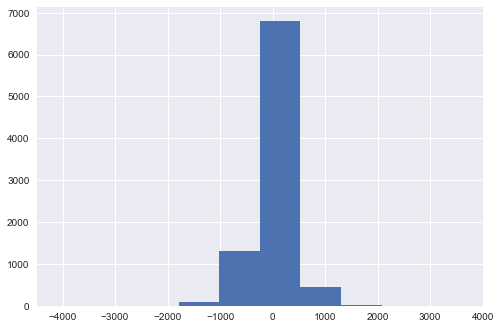

In [23]:
model_bt.transaction_history[model_bt.transaction_history['type'] == 0].pnl.hist()

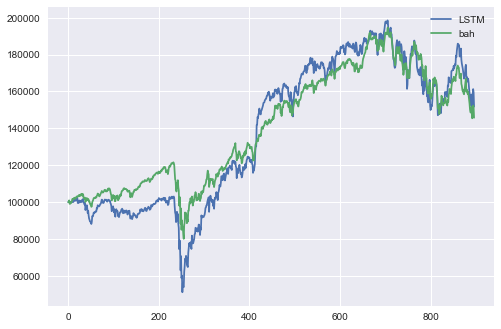

In [24]:
plt.plot(model_bt.portfolio_tracker['total_value'], label = 'LSTM')
plt.plot(model_bt.portfolio_tracker['bah'],label = 'bah')
plt.legend()

In [25]:
model_bt.upload_to_dashboard("LSTM")

Data uploaded.


In [30]:
model_bt.portfolio_tracker['bah'].pct_change().std()

0.014889202305635618

In [37]:
np.log(model_bt.portfolio_tracker['bah'].pct_change().fillna(0))

0          -inf
1          -inf
2     -4.651768
3           NaN
4           NaN
         ...   
892         NaN
893   -4.164791
894   -3.456321
895         NaN
896         NaN
Name: bah, Length: 897, dtype: float64

In [26]:
model_bt.transaction_history.to_csv("lstm_transactions.csv")
model_bt.portfolio_tracker.to_csv("lstm_portfolio_tracker.csv")

In [44]:
model_bt.portfolio_tracker['max'] = model_bt.transaction_history.dt[ model_bt.transaction_history.dt <  model_bt.transaction_history.dt.shift()]